## Introduction
This notebook aims to replicate the studies that were successful in predicting the lattice constants of the Perovskite crystal ($ABO_{3}$). The papers preoduced the results with the model's error around 2%. It's important to identify the features neccessary to perform predictions. The lattice constants of the $ABO_{3}$ -type may be correlated compounds as a general function of nine variables as below

$Lattice constant = f(z_A + z_B + z_O + r_A + r_B + r_O + x_A + x_B + x_O)$

where z, r and x denote the valence, the radius and the electronegativity of the ions (A, B, O), respectively. It is noted that the three variables associated with anion $O^{2-}$ , namely $z_{O}, r_{O},$ and $x_{O}$ can be ignored as they remain unchanged for all of the samples.

The lattice constant can be reduced as a ﬁve-parameter function shown below.

$Lattice constant = f(z_A + r_A + r_B + x_A + x_B)$

The Goldschmidt’s tolerance factor (t) can condense the coation atomic radii into one expression. It has been widely accepted as a criterion for the formation of the perovskite structure, up to now. I will use $\textbf{four features}$ including the tolerance factor and others are denoted by, $r_{A}, r_{B}$ and $\frac{r_{A}}{t}$. The list of feature does not include electronegativity and valence number. Basically, other sets of features that includes these two atomic configurations can be used to predict the lattice constant with great accuracy. However, I will only take the atomic radii of the two cations in to my account. The tolerance factor (t) is expressed as below.

$t = \frac{r_A + r_O}{\sqrt{2}(r_B + r_O)}$

## Procedure
First I will perform feature engineering. Next I will build the ANN (Hereafter called as ANN) model and also perform a GridSearch (GS). GS fine tunes the hyperparameters of the ANN. Finally I will perform the predictions from the model. The model will be prepared with the fine tuned hyperparameters. The GridSearch in the sklearn package convineintly provides the best model which can be used to fit and predict.

## Feature engineering
In the following section, the ".csv" file is loaded into the program. The data is inspected for assurity. I observed the '.csv' provides the atomic radii for two atoms A and B in the crystal ($r_{A}$ and $r_{b}$), and the tolerance factor is absent. So the tolerance factor and $\frac{r_{A}}{t}$ needs to be calculated. I have concanated them as columns in the following code.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# data structure
columns = ['compound',
    'atomic_ra', 'atomic_rb', 'atomic_rc',  # Atomic radius
    'covl_ra', 'covl_rb', 'covl_rc',  # Covalant radius
    'van_ra', 'van_rb', 'van_rc',  # Van der Wall radius
    'ionic_ra', 'ionic_rb', 'ionic_rc',  # Ionic radius
    'atomic_mass_a', 'atomic_mass_b', 'atomic_mass_c',  # Atomic mass
    'eNeg_a', 'eNeg_b', 'eNeg_c',  # Electronegativity
    'eAffin_a', 'eAffin_b', 'eAffin_c',  # Electron affinity
    'firstIoniz_a', 'firstIoniz_b', 'firstIoniz_c',  # First ionization potential
    'oxidation_a', 'oxidation_b', 'oxidation_c',  # Oxydation state
    'a', 'b', 'c', 'alpha', 'beta', 'gamma',  # Lattice parameters
    'BandGap',  # Band gap (some are metal too!)
    'formationE',  # Formation enerrgy per atom
]

lat_df = pd.read_csv('dataFile_new.csv', header=0,
                     index_col=0, usecols=columns)
print("The first five smaples from the DataFrame\n")
print(lat_df.head())


The first five smaples from the DataFrame

           atomic_ra  atomic_rb  atomic_rc  covl_ra  covl_rb  covl_rc  van_ra  \
compound                                                                        
Sr2YTaO6         2.0       1.80       1.45     1.92     1.62     1.38    2.55   
Sr2YReO6         2.0       1.80       1.35     1.92     1.62     1.59    2.55   
Sr2YIrO6         2.0       1.80       1.35     1.92     1.62     1.37    2.55   
Sr2CdWO6         2.0       1.55       1.35     1.92     1.48     1.46    2.55   
Sr2ScNbO6        2.0       1.60       1.45     1.92     1.44     1.37    2.55   

           van_rb  van_rc  ionic_ra  ...  oxidation_b  oxidation_c      a  \
compound                             ...                                    
Sr2YTaO6      2.4    2.20      1.12  ...            3            5  5.927   
Sr2YReO6      2.4    2.05      1.12  ...            3            5  5.909   
Sr2YIrO6      2.4    0.00      1.12  ...            3            5  5.880   
Sr2C

In [2]:

features = np.array(lat_df.loc[:, 'atomic_ra':'oxidation_c'], np.float32)
targets = np.array(lat_df.loc[:, 'a':'formationE'], np.float32)
# features = np.array(lat_df[['ra', 'rb', 'tolerance', 'rat']], np.float32)
# targets = np.array(lat_df[['a', 'b', 'c']], np.float32)

print ("\nThe first five observations of the features")
print (features[:5,:])
print ("\nThe first five observations of the targets")
print (targets[:5,:])


The first five observations of the features
[[2.0000000e+00 1.8000000e+00 1.4500000e+00 1.9200000e+00 1.6200000e+00
  1.3800000e+00 2.5500000e+00 2.4000001e+00 2.2000000e+00 1.1200000e+00
  8.9999998e-01 6.3999999e-01 8.7620003e+01 8.8905853e+01 1.8094788e+02
  9.4999999e-01 1.2200000e+00 1.5000000e+00 5.0200000e+00 3.0000000e+01
  3.1000000e+01 5.4950000e+02 6.0000000e+02 7.6100000e+02 2.0000000e+00
  3.0000000e+00 5.0000000e+00]
 [2.0000000e+00 1.8000000e+00 1.3500000e+00 1.9200000e+00 1.6200000e+00
  1.5900000e+00 2.5500000e+00 2.4000001e+00 2.0500000e+00 1.1200000e+00
  8.9999998e-01 5.7999998e-01 8.7620003e+01 8.8905853e+01 1.8620700e+02
  9.4999999e-01 1.2200000e+00 1.9000000e+00 5.0200000e+00 3.0000000e+01
  0.0000000e+00 5.4950000e+02 6.0000000e+02 7.6000000e+02 2.0000000e+00
  3.0000000e+00 5.0000000e+00]
 [2.0000000e+00 1.8000000e+00 1.3500000e+00 1.9200000e+00 1.6200000e+00
  1.3700000e+00 2.5500000e+00 2.4000001e+00 0.0000000e+00 1.1200000e+00
  8.9999998e-01 5.6999999e-01

### Standard Scaling

## Machine Learning Model

The prediction of lattice constants for $ABO_{3}$ from the atomic configurations like radii and tolerance has enigmatic mechanism. A linear regression model can not be conceived to solve multiple target variables. It can be deployed only in the case of single target variable. Here, the artificial neural network comes to the rescue. ANNs performance is remarkable for regression model. ANN works for any kind of numerical system.

For the ANN, I will choose the loss function as the mean absolute error. "MAE" does not penalise the outliers in predictions compared to mean square error and huber loss function. I will choose Adam optimizer over Stochastic gradient descent (SGD). Besides Adam optimizer the other hyperparameters are number of neural nodes, number of hidden layers, learning rate (Adam optimizer), activation functions and so on. The ANN has lots of hyperparameters to be tuned before I set out to predict the target variables. So a GS will be neccessary to narrow down the optimal set of hyperparameters.

A quick run down to my model's parameter is below.
1. Number of epochs = 350
2. Train and test data split ratio = 80:20
3. Number of hidden layers = 2
4. Number of neurons in each hidden layer = 400

Once the model finishes its job, the loss (mean absolute error) and the graph for train and test loss against number of epochs is shown. Next, I will perform the GridSearch.

Epoch 1/350
3/3 [==============================] - 1s 136ms/step - loss: 88.3987 - val_loss: 49.4029
Epoch 2/350
3/3 [==============================] - 0s 24ms/step - loss: 39.4946 - val_loss: 17.1264
Epoch 3/350
3/3 [==============================] - 0s 23ms/step - loss: 18.0716 - val_loss: 15.5915
Epoch 4/350
3/3 [==============================] - 0s 27ms/step - loss: 12.4690 - val_loss: 13.8584
Epoch 5/350
3/3 [==============================] - 0s 25ms/step - loss: 12.4243 - val_loss: 10.2362
Epoch 6/350
3/3 [==============================] - 0s 28ms/step - loss: 9.2071 - val_loss: 10.8960
Epoch 7/350
3/3 [==============================] - 0s 25ms/step - loss: 8.8212 - val_loss: 9.4235
Epoch 8/350
3/3 [==============================] - 0s 57ms/step - loss: 8.2196 - val_loss: 9.2946
Epoch 9/350
3/3 [==============================] - 0s 37ms/step - loss: 7.4681 - val_loss: 8.5716
Epoch 10/350
3/3 [==============================] - 0s 43ms/step - loss: 6.9675 - val_loss: 8.4318
Epoch 1

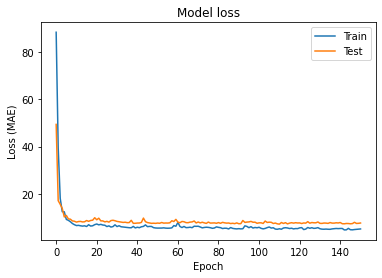


 The predicted values (Lattice constants)
[[  4.806473     5.6391287    6.1691356   60.30795     61.22253
   58.33371      1.2223157   -2.4170597 ]
 [  5.0072927    5.84006      6.449842    63.262474    63.122246
   60.278835     0.94721043  -2.520868  ]
 [  4.701872     5.534913     6.080666    55.6422      57.769695
   54.60162      1.1934577   -2.506455  ]
 [  5.0083513    5.889811     9.1514845   68.06251     84.25803
   80.05985      1.6399779   -2.6132166 ]
 [  4.6772738    5.779215     7.716773    81.83964     85.38619
   81.73161      1.9769601   -2.6908898 ]
 [  4.5496817    5.7603626   10.577125    91.09884     83.4223
  105.8154       1.4289654   -1.697421  ]
 [  4.833864     5.8830132    7.1179338   71.066086    72.70717
   65.9529       1.184789    -2.6120882 ]
 [  4.7977695    5.8286905    6.575237    71.78194     69.49605
   64.7786       1.8478924   -2.8879707 ]
 [  4.60826      5.660483     5.3095765   60.27564     58.502438
   58.42551      2.2562847   -2.3530762 ]
 

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from matplotlib import pyplot as plt

# The seed is required for replication of results. Parameters defined.
seed = 1111
tolerance_value = 40
n_epochs = 350

X_train, X_test, y_train, y_test = train_test_split(features, targets,
                                                    random_state=seed,
                                                    test_size=0.2)

def build_model(n_hidden=4, n_neurons=1400, learning_rate=1e-3, input_shape=[features.shape[1],]):
    model = keras.Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(targets.shape[1]))

    model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr=learning_rate))

    return model

# The wrapper is neccessary for GridSearch later in this notebook
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# The history dictionary is useful for 'loss' plot of the model. In this case, the 'loss' is mean absolute error 
history = keras_reg.fit(X_train, y_train, epochs=n_epochs,
              validation_data=(X_test, y_test),
              callbacks=[keras.callbacks.EarlyStopping(patience=tolerance_value)])

# Test on the holdout data
mae_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss (MAE)")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()


print ("\n The predicted values (Lattice constants)")
print (y_pred)
print ("\n The mean absolute error (MAE)")
print (mae_test)

## GridSearch
Grid search (GS) as the name suggests requires a grid made up by the hyperparamters. The alogorithm then runs the model over the grid and finds the best set of parameters for which the model perform best, i.e. low error (MSE, MAE, huber loss, etc in case of refression). The algorithm is heavy because it is performing a brute force approach. There are some techniques like Bayesian inference methods which are very quick in findig the hyperparameters. 

In the GS, I will set cross-validation option which results in more accurate loss metrics. Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set.

The parameter grid for my models are bulleted below.

1.   number of hidden layers (n_hidden)
2.   number of neural nodes in each hidden layers (n_neurons)
3.   learning rate for Adam optimizer

Since GS is a type of brute force approach I have employed a callback function which will terminate the GS once the patience level is crossed. This way I do not have to lose the computational power once the model loss starts saturating. 

In [9]:
# GridSearch for the ANN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# param_distribs = {
#     "n_hidden": [1, 2, 3, 4],
#     "n_neurons": [900, 1100, 1300, 1500],
#     "learning_rate": [1e-2, 1e-3],
# }

tolerance_value = 25

param_distribs = {
    "n_hidden": [2, 3, 4],
#   "n_neurons": [5500, 5700, 5900],
    "n_neurons": [350, 400, 450],
    "learning_rate": [5*1e-4, 5*1e-5],
}

search_cv = GridSearchCV(estimator= keras_reg,
                         param_grid= param_distribs, 
                         cv= 4, 
                         #scoring= make_scorer(mean_absolute_error, greater_is_better=True),
                         scoring ='neg_mean_absolute_error',
                         #refit=False,
                         n_jobs= -1)


# Best estimator is selected for further proceedings
grid_result = search_cv.fit( X_train, y_train)
#                   validation_data=(X_test, y_test),
#                   callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=tolerance_value)])


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("mean: %f, std: (%f) parameters: %r" % (mean, stdev, param))

3/3 [==============================] - 0s 3ms/step - loss: 6.2476
Best: -6.038357 using {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 400}
mean: -6.130315, std: (0.048170) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 350}
mean: -6.108383, std: (0.063690) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 400}
mean: -6.114991, std: (0.049127) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 450}
mean: -6.098228, std: (0.056253) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 350}
mean: -6.038357, std: (0.017768) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 400}
mean: -6.042637, std: (0.046752) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 450}
mean: -6.114984, std: (0.034185) parameters: {'learning_rate': 0.0005, 'n_hidden': 4, 'n_neurons': 350}
mean: -6.073250, std: (0.037417) parameters: {'learning_rate': 0.0005, 'n_hidden': 4, 'n_neurons': 400}
mean: -6.049508, std:

The result from GS is in. And the quick look can be done in following bullets
- number of hidden layers (n_hidden) = 2
- number of neural nodes in each hidden layers (n_neurons) = 450
- learning rate for Adam optimizer = 0.0005

I will now extract the best performing model from the GS object. This model is already set up with the set of hyperparameters for which the loss was minimium. The outcome of the model is same as before and is appended to the code.


History object

Epoch 1/350
3/3 [==============================] - 0s 45ms/step - loss: 6.2216 - val_loss: 6.0031
Epoch 2/350
3/3 [==============================] - 0s 10ms/step - loss: 5.9163 - val_loss: 5.6889
Epoch 3/350
3/3 [==============================] - 0s 9ms/step - loss: 5.5811 - val_loss: 5.2760
Epoch 4/350
3/3 [==============================] - 0s 9ms/step - loss: 5.1371 - val_loss: 4.7239
Epoch 5/350
3/3 [==============================] - 0s 10ms/step - loss: 4.5360 - val_loss: 3.9688
Epoch 6/350
3/3 [==============================] - 0s 9ms/step - loss: 3.7157 - val_loss: 2.9443
Epoch 7/350
3/3 [==============================] - 0s 9ms/step - loss: 2.6031 - val_loss: 1.5646
Epoch 8/350
3/3 [==============================] - 0s 10ms/step - loss: 1.2881 - val_loss: 1.1910
Epoch 9/350
3/3 [==============================] - 0s 9ms/step - loss: 1.1900 - val_loss: 1.2372
Epoch 10/350
3/3 [==============================] - 0s 10ms/step - loss: 1.2581 - val_loss: 1.1176
Epoch 1

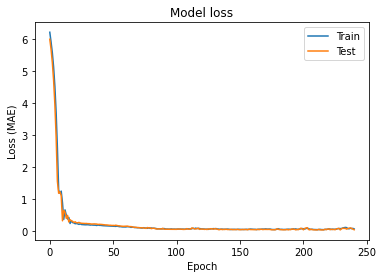


 Best Model's Parameters
{'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 400, 'build_fn': <function build_model at 0x14fac79d0>}

 The mean absolute error (MAE)
1/1 [==============================] - 0s 14ms/step - loss: 0.0510
-0.05099866911768913

 The predicted values (Lattice constants)
[[5.721018  8.1431465 5.770982 ]
 [5.294674  7.414089  5.204614 ]
 [5.562887  7.76776   5.44067  ]
 [5.493543  7.7195153 5.429098 ]
 [5.4776645 7.564986  5.2622256]
 [5.5509987 7.6060762 5.262974 ]
 [5.566989  7.8174243 5.4949493]
 [5.4957247 7.7444143 5.4562454]
 [5.551647  7.652378  5.315756 ]
 [5.492405  7.706978  5.4154563]
 [5.55021   7.639229  5.3016315]
 [5.472857  7.5248795 5.2194047]
 [5.5530467 7.6654596 5.3298283]
 [5.822979  7.5002275 4.9404397]
 [5.8852873 8.31454   5.862657 ]
 [5.5530467 7.6654596 5.3298283]
 [5.562887  7.76776   5.44067  ]
 [6.0935845 8.706195  6.180487 ]
 [5.3469887 7.513208  5.2851725]
 [5.615102  7.866869  5.521264 ]]


In [10]:
best_model = grid_result.best_estimator_

print ("\nHistory object\n")
best_model_history = best_model.fit(X_train, y_train, epochs=n_epochs,
              validation_data=(X_test, y_test),
              callbacks=[keras.callbacks.EarlyStopping(patience=tolerance_value)])
              
plt.figure()
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss (MAE)")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()

print ("\n Best Model's Parameters")
print (best_model.get_params())
print ("\n The mean absolute error (MAE)")
print (best_model.score(X_test, y_test))
print ("\n The predicted values (Lattice constants)")
print (best_model.predict(X_test))

## Conclusion

In this notebook too I deployed the ANN and found was successful in predicting the lattice constants with the mean absolute error around -0.05. The GridSearch did not perform well I would have expected it do. However, it along a few techniques like feature scaling and the commented out linear model is next task in my schedule. 

This notebook could not be amongst the best performer. However, especially after building an ANN I am motivated to work further on Machine Learning domain. I have all the incentives to move ahead. 

## References

[1] Chonghe, Li, et al. "Prediction of lattice constant in perovskites of GdFeO3 structure." Journal of Physics and Chemistry of Solids 64.11 (2003): 2147-2156.

[2] Alade, Ibrahim Olanrewaju, Ismail Adewale Olumegbon, and Aliyu Bagudu. "Lattice constant prediction of A2XY6 cubic crystals (A= K, Cs, Rb, TI; X= tetravalent cation; Y= F, Cl, Br, I) using computational intelligence approach." Journal of Applied Physics 127.1 (2020): 015303.

[3] Jiang, L. Q., et al. "Prediction of lattice constant in cubic perovskites." Journal of Physics and Chemistry of Solids 67.7 (2006): 1531-1536.

[4] “Introduction to Machine Learning with Python, A Guide for Data Scientists", by Andreas C. Müller and Sarah Guido

[5] “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", by Aurélien Géron

[6] "The Hundred-Page Machine Learning Book", by Andriy Burkov